In [2]:
using  FFTW
using  LinearAlgebra
using  ProgressMeter
using  BenchmarkTools
using  Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
struct Mesh
    
    N   :: Int
    xmin :: Float64
    xmax :: Float64
    dx   :: Float64
    x    :: Vector{Float64}
    kmin :: Float64
    kmax :: Float64
    dk   :: Float64
    k    :: Vector{Float64}
    
    function Mesh( xmin, xmax, N)
        dx = (xmax-xmin)/N
        x = range(xmin, stop=xmax, length=N+1)[1:end-1]
        dk = 2π/(N*dx)
        kmin = -N/2*dk
        kmax = (N/2-1)*dk
        k = [range(0, length=N ÷ 2, step = dk) ; range(kmin, length=N ÷ 2, step = dk) ]
        new( N, xmin, xmax, dx, x, kmin, kmax, dk, k)
    end
end

In [4]:
struct Times
    
    Nt   :: Int
    tfin :: Float64
    dt   :: Float64
    t    :: Vector{Float64}
    
    function Times( dt, tfin)
        t = range(0, stop=tfin, step = dt)
        Nt = length(t)
        new( Nt, tfin, dt, t)
    end
end

In [5]:
struct Parameters
    
    epsilon :: Float64
    mu :: Float64
end

In [6]:
struct Datum
    
    h0 :: Array{Complex{Float64},1}
    u0 :: Array{Complex{Float64},1}
    
end

In [7]:
abstract type TimeSolver end
abstract type Model end
#A placer avant la def de RK4 qui utilise ces types

In [8]:
mutable struct RK4 <: TimeSolver
    
    hhat :: Vector{Complex{Float64}}
    uhat :: Vector{Complex{Float64}}
    dh   :: Vector{Complex{Float64}}
    du   :: Vector{Complex{Float64}}
    
    function RK4( n )
        
        hhat = zeros(Complex{Float64}, n)
        uhat = zeros(Complex{Float64}, n)
        du   = zeros(Complex{Float64}, n)
        dh   = zeros(Complex{Float64}, n)
        
        new( hhat, uhat, du, dh)
        
    end
    
end

function step!(s  :: RK4,
               m  :: Model,
               f  :: Function,
               h  :: Vector{Complex{Float64}},
               u  :: Vector{Complex{Float64}},
               dt :: Float64)
        
    s.hhat .= h
    s.uhat .= u
    f(m, s.hhat, s.uhat)
    s.dh .= s.hhat
    s.du .= s.uhat
    
    s.hhat .= h .+ dt/2*s.hhat
    s.uhat .= u .+ dt/2*s.uhat
    f(m, s.hhat, s.uhat)
    s.dh .+= 2 * s.hhat
    s.du .+= 2 * s.uhat
    
    s.hhat .= h .+ dt/2*s.hhat
    s.uhat .= u .+ dt/2*s.uhat
    f(m, s.hhat, s.uhat)
    s.dh .+= 2 * s.hhat
    s.du .+= 2 * s.uhat
    
    s.hhat .= h .+ dt*s.hhat
    s.uhat .= u .+ dt*s.uhat
    f(m, s.hhat, s.uhat)
    s.dh .+= s.hhat
    s.du .+= s.uhat
    
    h .+= dt/6 * s.dh
    u .+= dt/6 * s.du
end

mutable struct EulExp <: TimeSolver
    
    hhat :: Vector{Complex{Float64}}
    uhat :: Vector{Complex{Float64}}
    
    function EulExp( n )
        
        hhat = zeros(Complex{Float64}, n)
        uhat = zeros(Complex{Float64}, n)
        
        new( hhat, uhat)
        
    end
    
end

function step!(s  :: EulExp,
               m  :: Model,
               f  :: Function,
               h  :: Vector{Complex{Float64}},
               u  :: Vector{Complex{Float64}},
               dt :: Float64)
        
    s.hhat .= h
    s.uhat .= u
    f( m, s.hhat, s.uhat)
    
    h .+= dt * s.hhat
    u .+= dt * s.uhat
end
    

step! (generic function with 2 methods)

In [15]:
mutable struct Cheng <: Model
    
    mesh    :: Mesh
    label   :: String
    data    :: Vector{Tuple{Vector{Complex{Float64}},Vector{Complex{Float64}}}}
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    Px      :: FFTW.cFFTWPlan{Complex{Float64},-1,false,1}
    epsilon :: Float64
    hnew    :: Array{Complex{Float64},1}
    unew    :: Array{Complex{Float64},1}
    Int1    :: Array{Complex{Float64},1}
    Int2    :: Array{Complex{Float64},1}
    Int3    :: Array{Complex{Float64},1}

    function Cheng()
        label = "Cheng et al."
        data  = []
        Gamma = abs.(mesh.k)
        epsilon= parameters.epsilon
        Dx    =  1im * mesh.k            # Differentiation
        H     = -1im * sign.(mesh.k)     # Hilbert transform
        Pi    = Gamma .< mesh.kmax * 2/3 # Dealiasing low-pass filter
        h0=initial_data.h0
        Px  = plan_fft(h0; flags = FFTW.MEASURE)
        hnew, unew ,Int1, Int2, Int3 = similar(h0), similar(h0), similar(h0), similar(h0), similar(h0)
        new(mesh, label, data, Gamma, Dx, H, Pi, Px, epsilon, hnew, unew, Int1, Int2, Int3)
    end
end

function init(m :: Cheng, datum::Datum)
         
         return Datum(m.Pi.*fft(datum.h0),m.Pi.*fft(datum.u0))
end

function build(m :: Cheng, datum::Datum)
         
         return Datum(real(ifft(datum.h0)),real(ifft(datum.u0)))
end

function fwave!(m :: Cheng,
                    h::Vector{Complex{Float64}},
                    u::Vector{Complex{Float64}})
         
         ldiv!(m.hnew, m.Px , h)
         
         m.Int1  .= u
         m.Int1 .*= m.Gamma
         ldiv!(m.unew, m.Px , m.Int1)
         m.unew  .^= 2
         mul!(m.Int1, m.Px , m.unew)
         m.Int1 .*= m.H
         
         m.Int2  .= h
         m.Int2 .*= m.Dx
         ldiv!(m.unew, m.Px , m.Int2)
         m.unew  .*= m.hnew
         mul!(m.Int2, m.Px , m.unew)
         
         m.Int3  .= h
         m.Int3 .*= m.Gamma
         ldiv!(m.unew, m.Px, m.Int3)
         m.unew  .*= m.hnew
         mul!(m.Int3 , m.Px , m.unew)
         m.Int3 .*= m.H
         
         m.hnew  .= -u
         m.hnew .*= m.Dx
         
         m.Int1 .-= m.Int2
         m.Int1 .-= m.Int3
         m.Int1 .*= m.Pi
         m.Int1 .*= m.epsilon
         
         u  .= h
         u .*= m.H
         u .+= m.Int1
         
         h .= m.hnew
         
end

fwave! (generic function with 2 methods)

In [16]:
mutable struct Matsuno <: Model
    
    mesh    :: Mesh
    label   :: String
    data    :: Vector{Tuple{Vector{Complex{Float64}},Vector{Complex{Float64}}}}
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    Px      :: FFTW.cFFTWPlan{Complex{Float64},-1,false,1}
    epsilon :: Float64
    hnew    :: Array{Complex{Float64},1}
    unew    :: Array{Complex{Float64},1}
    Int1    :: Array{Complex{Float64},1}
    Int2    :: Array{Complex{Float64},1}
    Int3    :: Array{Complex{Float64},1}

    function Matsuno()
        label = "Matsuno"
        data  = []
        Gamma = abs.(mesh.k)
        epsilon= parameters.epsilon
        Dx    =  1im * mesh.k            # Differentiation
        H     = -1im * sign.(mesh.k)     # Hilbert transform
        Pi    = Gamma .< mesh.kmax * 2/3 # Dealiasing low-pass filter
        h0=initial_data.h0
        Px  = plan_fft(h0; flags = FFTW.MEASURE)
        hnew, unew ,Int1, Int2, Int3 = similar(h0), similar(h0), similar(h0), similar(h0), similar(h0)
        new(mesh, label, data, Gamma, Dx, H, Pi, Px, epsilon, hnew, unew, Int1, Int2, Int3)
    end
end


function init(m :: Matsuno, datum::Datum)
         
         return Datum(m.Pi.*fft(datum.h0),m.Pi.*fft(datum.u0))
end

function build(m :: Matsuno, datum::Datum)
         
         return Datum(real(ifft(datum.h0)),real(ifft(datum.u0)))
end

function fwave!(m :: Matsuno,
                    h::Vector{Complex{Float64}},
                    u::Vector{Complex{Float64}})
         
        m.hnew .= m.Gamma .* h         
        ldiv!(m.unew, m.Px, m.hnew )   
        m.hnew .= m.Dx .* h            
        ldiv!(m.Int1, m.Px, m.hnew)    
        m.unew .*= m.Int1            
        mul!(m.Int1, m.Px, m.unew)     
        m.Int1 .*= m.epsilon*m.Pi
        m.Int1 .-= m.Dx .* h 
        ldiv!(m.hnew, m.Px, h)
        ldiv!(m.unew, m.Px, u)
        m.Int2  .= m.hnew .* m.unew
        mul!(m.Int3, m.Px, m.Int2)
        m.Int3 .*= m.Dx
        h     .= m.H.*u
        u    .*= m.Gamma
        ldiv!(m.Int2, m.Px, u)
        m.Int2 .*= m.hnew
        mul!(u, m.Px, m.Int2)
        u    .*= m.H
        m.Int3 .+= u
        m.Int3 .*= m.epsilon * m.Pi
        h    .-= m.Int3     
        m.Int3  .= m.unew.^2
        mul!(m.unew, m.Px, m.Int3)
        m.unew  .*= m.Dx
        m.unew  .*= m.epsilon/2 * m.Pi 
        m.Int1  .-= m.unew
        u .= m.Int1
end

fwave! (generic function with 2 methods)

In [23]:
function solve!(model::Model, init_datum::Datum, parameters::Parameters, mesh::Mesh, times::Times, solver::TimeSolver)
    
    prog = Progress(times.Nt,1) # progress bar
    
    h = init(model, init_datum).h0
    u = init(model, init_datum).u0

    model.data = [] #pourquoi je ne peux pas commenter cette ligne ?
  
    push!(model.data,(copy(h),copy(u)))
    for l in range(1,times.Nt-1)
        
        dt = times.t[l+1]-times.t[l]
        
        step!( solver, model, fwave!, h, u, dt)
    
        push!(model.data,(copy(h),copy(u)))   
        next!(prog)
    end
            
end

solve! (generic function with 1 method)

In [24]:
function fig(t, times::Times, models, mesh::Mesh)
        
    if indexin(false,times.t.<=t)[1]==nothing
        index=length(times.t)
        else index=indexin(false,times.t.<=t)[1]-1
    end
    t=times.t[index]
    
    p = plot(layout=(2,1))
    
    for model in models
        datum=Datum(model.data[index][1],model.data[index][2])
        (h,u)=(real(build(model, datum).h0),real(build(model, datum).u0))
        plot!(p[1,1], mesh.x,h; label=model.label)
        plot!(p[2,1], fftshift(model.mesh.k),log10.(1e-18.+abs.(fftshift(fft(h)))); 
            label=model.label)  
    end
    
    display(p)
end

fig (generic function with 1 method)

(epsilon, N, L, T, dt) = (0.5, 4096, 10, 5, 0.001)
*** Cheng et al. ***

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:00

 12.404390 seconds (478.52 k allocations: 5.517 GiB, 20.79% gc time)
*** Matsuno ***

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

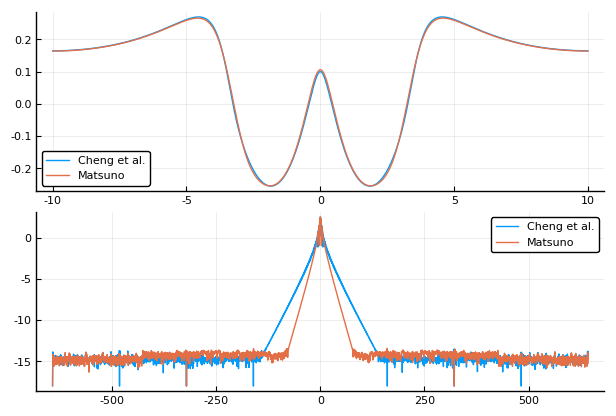

 14.765146 seconds (619.13 k allocations: 6.133 GiB, 17.89% gc time)


In [25]:
epsilon = 1/2
mu      = 0
N       = 2^12
L       = 10
T       = 5
dt      = 0.001

@show epsilon,N,L,T,dt

parameters=Parameters(epsilon,mu)
mesh  = Mesh(-L, L, N)
times = Times(dt, T)
initial_data = Datum(exp.(-(mesh.x).^2),zeros(Complex{Float64}, mesh.N))
#h0=exp.(-(mesh.x).^2)
#u0=zeros(Complex{Float64}, mesh.N)
#initial_datas = Datas(h0,u0)

models = []
push!(models, Cheng())
push!(models, Matsuno())
 
#function run_simulations(mesh::Mesh, models, initial_data::InitialData, parameters::Parameters, times::Times)

solver = RK4( mesh.N )

    for model in models
        
        print("*** $(model.label) ***")
        @time solve!(model, initial_data, parameters, mesh , times, solver)
    end
#end
#run_simulations(mesh, models, initial_data, parameters, times)


fig(5, times, models, mesh)

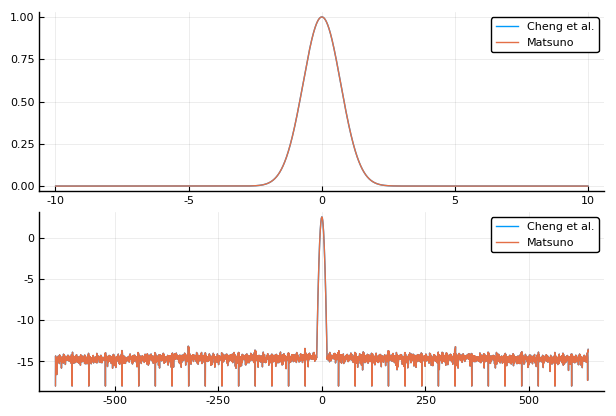

In [26]:
fig(0, times, models, mesh)